![](../logo.png)
# Introduction to statistical inference: count data
## Yoav Ram

**Statistical inference** uses data and scientific and statistical models to explain observable phenomena using mathematical and computational methods.
See [Kass 2011](http://www.stat.cmu.edu/~kass/papers/bigpic.pdf) for further discussion.

We will start with a relatively simple problem: inference from count data. 
**Count data** refers to data that represents the number of occurrences of an event within a fixed period of time, space, or other defined observation unit. The values are non-negative integers (e.g., 0, 1, 2, 3, ...).

Examples include:
- The number of emails received in a day.
- The number of species observed in a plot.
- The number of accidents at an intersection over a month.

Count data is typically modeled using distributions suited for non-negative integers, such as the **Poisson distribution** (for rare events occurring independently) or the **negative binomial distribution** (for overdispersed count data).


__MCB:__   
    - PINN (Physics informed NN)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np #jax.numpy can run on CPU/GPU/TPU
import jax
from jax import random
from jax.scipy import stats
from scipy import optimize
from numpy import loadtxt
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, blue, green = sns.color_palette('Set1', 3)

# Poisson model for count data

Imagine that we count the number of [European red mites](https://en.wikipedia.org/wiki/Panonychus_ulmi) on apple leaves.

Denote the number of leaves by $n$, where the $i^{\rm th}$ measurement $x_i$ reports the observed number of mites on leaf $i$.
We assume that $x_i$ is Poisson-distributed around the expected number of mites $\mu$, 
$$
x_i \sim \text{Poisson}(\mu)
$$

So $\text{Poisson}(\mu)$ is our **model**, **$\mu$** is the **model parameter**, and $\{x_i\}_{i=1}^n$ are the **data**.

This is a **generative model**: it explains how the data is generated and, if we find a good estimate of $\mu$, allows us to generate more data from the same distribution of the observed data.

The question is, given this data $\{x_i\}$, **what is our best estimate of $\mu$?** 

Generating this estimate an objective of **statistical inference**: making conclusions on observable phenomea by applying mathematical methods to data and models.

We start by simulating data before using real data.

__MCB:__
- _JAX_ completely immutable.
- No internal state. No way to create randomness !
- Create `key` with a random number. That `key` has the random state.
- Then we use `split` to split the `key` into two, where we will keep `key` for future use as seed, and we can consume `subkey` to generate randomness/stocasticity.

In [6]:
key = random.key(1202) # generate a random number key

# expected number of mites on a leaf
μ = 10  
# number of measurements
n = 150 
# n measurements of the mites
key, subkey = random.split(key)
X = random.poisson(subkey, μ, shape=(n,)) # see note for subkey usage.

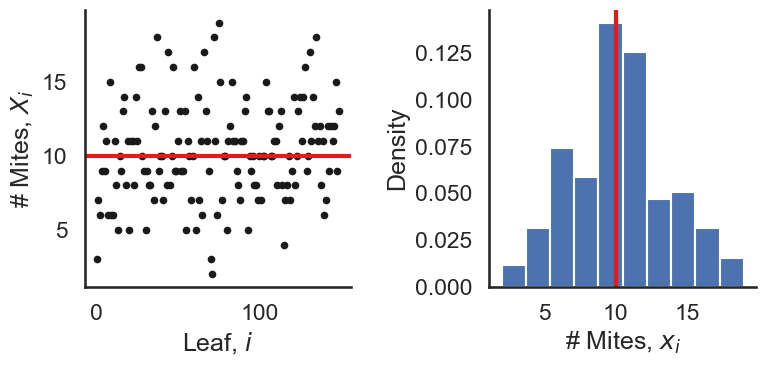

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Leaf, $i$")
ax.set_ylabel("# Mites, $X_i$")

ax = axes[1]
ax.hist(X, bins=10, density=True)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Density")
ax.set_xlabel("# Mites, $x_i$")

fig.tight_layout()
sns.despine()

In this toy example we already know the
true value of $\mu$, but the question is this: **given our measurements $X=(x_1, \ldots, x_n)$, what is our best estimate of the true $\mu$?**

# Maximum likelihood estimation with Poisson distribution

> The most common approach to parameter estimation is to pick the parameters that assign the highest probability to the training data; this is called **maximum likelihood estimation or MLE**. (ProbML, ch. 4.2)

We define the MLE as:
$$
\hat{\mu} \coloneqq \text{argmax}_{\mu} \; p(X \mid \mu)
$$

We assume the Poisson distribution, so the likelihood given a single observation $x_i$ is given by the probability mass function,
$$
x_i \sim \text{Poisson}(\mu) \Rightarrow 
p(x_i \mid \mu) = \frac{\mu^{x_i} e^{-\mu}}{x_i!}
$$
We usually assume the training examples are independently sampled from the same distribution (the **iid assumption**), so the likelihood becomes
$$
p(X \mid \mu) = \prod_{i=1}^{n}{p(x_i \mid \mu)} = 
\prod_{i=1}^{n}{\frac{\mu^{x_i} e^{-\mu}}{x_i!}}
$$

In this case (and in most cases) it is easier to work with the **log likelihood** (products become sums etc.), given by
$$
\ell(\mu) \coloneqq \log\;p(X \mid \mu) = 
\sum_{i=1}^{n}{\log\left(p \left(x_i \mid \mu\right)\right)}
$$
Since log is a monotone increasing function, 
$$
\hat{\mu} = \text{argmax}_{\mu} \; \ell(\mu)
$$

In our Poisson model, the log likelihood is 
$$
\ell(\mu) = 
\sum_{i=1}^{n}{\log\left(\frac{\mu^{x_i} e^{-\mu}}{x_i!}\right)} =
\sum_{i=1}^{n}{\left[x_i \log(\mu) -\mu - \log(x_i!)\right]}
$$

### Analytic solution for the estimator

We can find $\hat{\mu}$ analytically. 

First, we find the derivative of the log likelihood,
$$
\frac{d\ell}{d\mu} =
\frac{d}{d\mu} \sum_{i=1}^{n}{\left[x_i \log(\mu) + -\mu - \log(x_i!)\right]} =
\sum_{i=1}^n{\left[\frac{x_i}{\mu} - 1\right]} =
\frac{\sum_{i=1}^n{x_i}}{\mu} - n
$$
Next, we find the solution $\hat{\mu}$ for $\frac{d\ell}{d\mu} = 0$,
$$
\frac{\sum_{i=1}^n{x_i}}{\hat{\mu}} - n = 0 \Rightarrow \\\\
\hat{\mu} = \frac{1}{n}\sum_{i=1}^n{x_i}
$$
So the MLE estimate $\hat{\mu}$ is the **arithmetic mean**, $\bar{X}=\frac{1}{n}\sum_{i=1}^n{x_i}$.

In [8]:
print("μ* = {} \nμ_hat = {:.4f}".format(μ, X.mean()))

μ* = 10 
μ_hat = 10.2933


### Numerical solution for the estimator

If we can't do the analysis (or we are too lazy), we can find $\hat{mu}$ by using an optimization algorithm (ch. 8 in ProBML).
Most optimization algorithms are designed to minimize loss functions (rather than maximize them), so we use the **negative log likelihood** (NLL) as a **loss function** or **cost function***,
$$
\text{NLL}(\mu) \coloneqq -\log p(X\mid \mu) = -\sum_{i=1}^{n}{\log p \left(x_i \mid \mu\right)}
$$

Let's implement the `NLL(μ)` function, which takes $\mu$, the model parameter, and returns the negative log likelihood$\ell(\mu)$, the negative log likelihood. The function uses $X$, the data, but only as a global variable.

In [9]:
def NLL(μ, X): # mu (1000,), X (150,)
    X = X.reshape((-1, 1)) # for broadcasting when μ is an array. X = (150, 1) -> (150, 1000)
    return -stats.poisson.logpmf(X, μ).sum(axis=0) # (1000,) -> (1, 1000) -> (150, 1000) sum over axis 0 -> (1000,)

In [12]:
μ_range = np.linspace(8, 12, 1000)
nlls = NLL(μ_range, X)
μ_hat = μ_range[nlls.argmin()]
print("μ* = {} \nμ_hat = {:.4f}".format(μ, μ_hat))

μ* = 10 
μ_hat = 10.2903


Here's a plot of the log likelihood function, with the true value of $\mu$ and the mle.

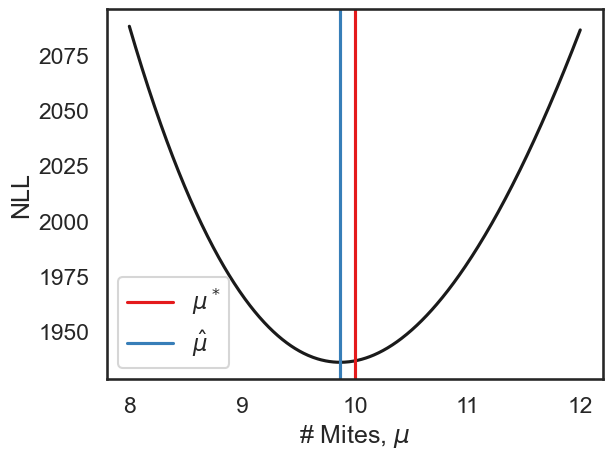

In [18]:
# Redraw different sample of data:
key, subkey = random.split(key)
X = random.poisson(subkey, μ, shape=(n*5,)) # larger the sample size, better the estimate.
μ_range = np.linspace(8, 12, 1000)
nlls = NLL(μ_range, X)
μ_hat = μ_range[nlls.argmin()]


plt.plot(μ_range, nlls, color='k')
plt.axvline(μ, color=red, label=r'$\mu^*$')
plt.axvline(μ_hat, color=blue, label=r'$\hat{\mu}$')
plt.xlabel(r"# Mites, $\mu$")
plt.ylabel("NLL")
plt.legend();

# Sampling distribution
In frequentist (non-Bayesian) statistics, we can represent uncertainty by calculating how a quantity estimated from data changes if the data change (ProbML ch. 4.7). 

Let's consider the **estimator**, $\hat{\mu}(\cdot)$. When we apply it to data $X$, we get the **estimand** $\hat{\mu}(X)$. 
The data $X$ is a sample from the unknown theoretical distribution $p^*(X)$, which induces the **sampling distribution** over the estimand, $p^*(\hat{\mu})$.

In simple cases (like we have here with the Poisson distribution), the sampling distribution can be calculated analytically. But in more complex cases (which are most interesting cases), we can approximate the sampling distribution using **the bootstrap** method. 

If we know the real parameter $\mu^*$, we can sample multiple datasets from the distribution $p(X \mid \mu^*)$ and then estimate the parameter then we get a set of estimates. This approximates the sampling distribution.

# The bootstrap
But usually we don't know $\mu^*$. Instead, we can use the data itself as an empirical approximation of the theoretical distribution $p(X\mid \mu^*)$. 
We can generate $N$ datasets $\{\tilde X^{(i)}\}_{i=1}^{N}$ by sampling with replacement from the real dataset $X$. We can then apply the estimator to get a set of estimates $\{\tilde{\mu}^{(i)}\}_{i=1}^{N}$ that approximates the sampling distribution. This is called the **bootstrap** technique (ProbML ch. 4.7.3).

A nice visualization is available on [Seeing Theory](https://seeing-theory.brown.edu/frequentist-inference/index.html#section3).

Note: this is the non-parametric bootstrap; the parametric bootstrap is when we sample $\tilde X^{(i)} \sim p(X \mid \hat{\mu})$.

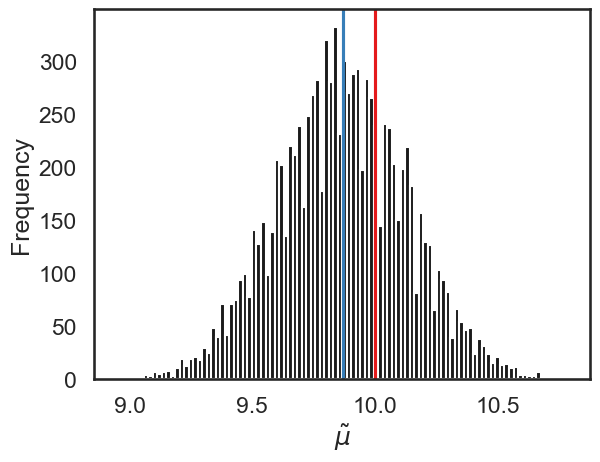

In [19]:
N = 10000
key, subkey = random.split(key)
Xs = random.choice(subkey, X, shape=(N,n), replace=True)
μ_hats = Xs.mean(axis=1)
plt.hist(μ_hats, 100, color='k')
plt.axvline(μ, color=red, label=r'$\mu^*$')
plt.axvline(μ_hat, color=blue, label=r'$\hat{\mu}$')
plt.xlabel(r'$\tilde\mu$')
plt.ylabel('Frequency');

In many cases, the sampling distribution is normal and centered around the real parameter value (the format condition for this is that the parameters are identifiable).

# Confidence intervals

The variance of the sampling distribution can be used to estimate uncertainty in the parameter estimate. 
A common approach is to define a 100(1-$\alpha$)% **confidence interval** (CI) for $\mu$ as an etimator that results an interval that captures the true parameter with probability of at least $1-\alpha$ (it is common to use $\alpha=0.05$ for a 95% CI.)


95% CI: 9.35-10.39


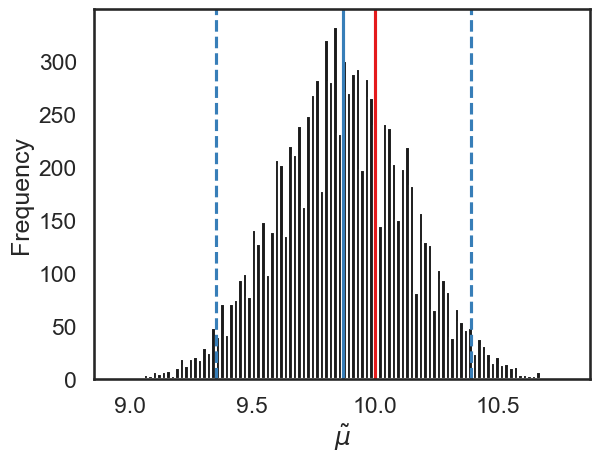

In [20]:
α = 0.05
ci_low = np.quantile(μ_hats, α/2)
ci_high = np.quantile(μ_hats, 1-α/2)
print('95% CI: {:.2f}-{:.2f}'.format(ci_low, ci_high))

plt.hist(μ_hats, 100, color='k')
plt.axvline(μ, color=red, label=r'$\mu^*$')
plt.axvline(μ_hat, color=blue, label=r'$\hat{\mu}$')
plt.axvline(ci_low, color=blue, ls='--',)
plt.axvline(ci_high, color=blue, ls='--')
plt.xlabel(r'$\tilde\mu$')
plt.ylabel('Frequency');

You can see that the 95% CI is wide, covering a range from 9.5 to 10.6.

Also, from its contruction, the 95% CI will contain the true value 95% of the time, that is, if we repeatedly sample datasets $\tilde X$ from $\mu^*$ and compute their CIs, then we have probability of 0.95 to have $\mu^*$ in the CI. 

# Bias of an estimator

The bias of the estimator is defined as (ProbML, ch. 4.7.6)
$$
\text{bias}(\hat{\mu}(\cdot)) \coloneqq \mathbb{E}\left[\hat{\mu}(X)\right] - \mu^*
$$
where $\mu^*$ us the true parameter value, and the expectation $\mathbb{E}$ is with respect to the theoretical distribution $p(X\mid \mu^*)$.
If the bias is zero, the estimator is called **unbiased**.

In our Poisson model,
$$
\text{bias}(\hat{\mu}) = 
\mathbb{E}\left[\bar{X}\right] - \mu = 
\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^{n}{x_i}\right] - \mu^* =
\frac{1}{n}\sum_{i=1}^{n}{\mathbb{E}[x_i]}  - \mu^* =
\frac{1}{n}\sum_{i=1}^{n}{\mu^*}  - \mu^* = 0
$$
So our estimate is unbiased.

# Variance of the estimator
Being unbiased in not enough. For example, we could estimate $\hat{\mu}=X_1$ from just the first observation and it would still be unbiased. But it will often be further from the true value compared to the empiricial mean $\bar{X}$. 
So the variance of an estimator is also important.

The variance, which measures how our estimate changes when the data changes, is defined as
$$
\mathbb{V}[\hat{\mu}] \coloneqq \mathbb{E}\left[\hat{\mu}^2\right] - \left(\mathbb{E}\left[\hat{\mu}\right]\right)^2
$$
where the expectation $\mathbb{E}$ is with respect to the theoretical distribution $p(X\mid \mu^*)$.

How low can the variance go? 
The **[Cramér–Rao lower bound](https://en.wikipedia.org/wiki/Cramér–Rao_bound)** provides a lower bound on the varaince on an unbiased estimator (under some smoothness assumptions on $p(X \mid \mu^*)$), 
$$
\mathbb{V}[\hat{\mu}] \ge \frac{1}{\mathcal{F}(\mu^*)}
$$
where $\mathcal{F}$ is Fisher information, defined as:
$$
\mathcal{F}(\mu) = - \mathbb{E}\left[\frac{d^2 \ell(\mu)}{d\mu^2} \right]
$$
where the expectation $\mathbb{E}$ is with respect to the theoretical distribution $p(X\mid \mu^*)$.

Importantly, the MLE achieves this lower bound and is therefore said to be asymptotically optimal.

So, in our Poisson model we have
$$
\frac{d\ell}{d\mu} =
\frac{1}{\mu} \sum_{i=1}^n{x_i} - n \Rightarrow $$$$
\frac{d^2\ell}{d\mu^2}  =
-\frac{1}{\mu^2} \sum_{i=1}^n{x_i} \Rightarrow $$$$
\mathcal{F}(\mu^*) =
- \mathbb{E}\left[-\frac{1}{(\mu^*)^2} \sum_{i=1}^n{x_i} \right] = 
\frac{1}{(\mu^*)^2} \mathbb{E}\left[ \sum_{i=1}^n{x_i} \right] =
\frac{n \mu^*}{(\mu^*)^2} =
\frac{n}{\mu^*} 
\Rightarrow $$$$
\mathbb{V}(\hat{\mu}) \ge \frac{\mu^*}{n}
$$

In [21]:
print("V[μ_hat]={:.2f} >= μ/n={:.2f}".format(μ_hats.var(), μ/n))

V[μ_hat]=0.07 >= μ/n=0.07


# The bias-variance tradeoff

When picking a method for parameter estimation, we usually want to minimize the mean squared error (MSE) of our estimate. 
We write $\bar{\mu}=\mathbb{E}[\hat{\mu}]$ for the expected value of the estimate (expectation taken over the data as before).
So we have
$$
\mathbb{E}\left[\left(\hat{\mu} - \mu^*\right)^2\right] = 
\mathbb{E}\left[\left(\hat{\mu} - \mathbb{E}[\hat{\mu}] + \mathbb{E}[\hat{\mu}] - \mu^*\right)^2\right] = $$$$
\mathbb{E}\left[\left(\hat{\mu}-\mathbb{E}[\hat{\mu}]\right)^2\right] + \left(\mathbb{E}[\hat{\mu}]-\mu^*\right)^2 = $$$$
\mathbb{V}\left[\hat{\mu}\right] + \text{bias}^2(\hat{\mu})
$$
That is, $\text{MSE} = \text{variance} + \text{bias}^2$.
So if we want to minimize the MSE, we might consider a biased estimator if it reduces the variance by more than a square of the bias.

In the Poisson model, a biased estimator $\tilde \mu = c \hat{\mu}$ can have lower variance and might therefore reduce the MSE.

Minimum MSE=0.017 at c=1.0000 with μ=9.8699


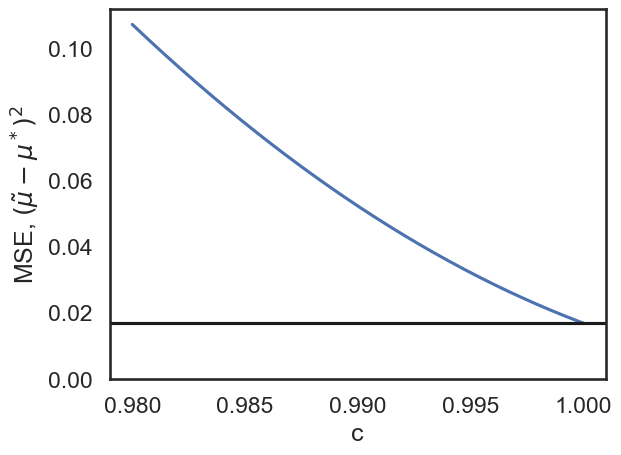

In [22]:
c = np.linspace(0.98, 1, 1000)
μ_bias = c * μ_hat
mse = (μ_bias - μ)**2
plt.plot(c, mse)
# plt.axvline(1, color='k')
plt.axhline((μ_hat - μ)**2, color='k')
plt.xlabel('c')
plt.ylabel(r'MSE, $(\tilde\mu - \mu^*)^2$')
plt.ylim(0, None);
print("Minimum MSE={:.2g} at c={:.4f} with μ={:.4f}".format(
    mse.min(), c[mse.argmin()], μ_bias[mse.argmin()]))

# Model checking

In the Poisson model, the mean to variance ratio should be 1.

In [23]:
print(r'Avg(X)'+'={:.4f}, Var(X)={:.4f}'.format(X.mean(), X.var(ddof=1)))
print('Avg(X)/Var(X) =', X.mean() / X.var(ddof=1) )

Avg(X)=9.8707, Var(X)=10.4305
Avg(X)/Var(X) = 0.9463263


We got a value lower than 1. But is it significantly lower?
We can check if the model is consistent with the data by comparing the ratio of the mean and variance of the data and comparing it to the ratio of mean and variance generated by the best fit model.

So we generate lots of datasets from the best fit model and compute their mean to variance ratio, then show the histogram and 95% CI of the ratios.

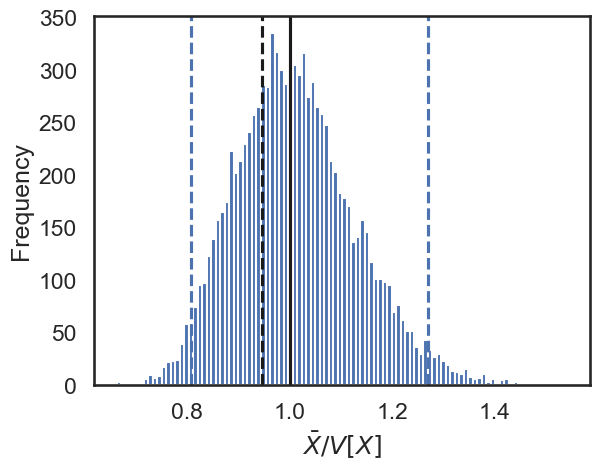

In [24]:
key,subkey = random.split(key)
Xs = random.poisson(subkey, μ_hat, shape=(N,n))
ratios = Xs.mean(axis=1)/Xs.var(ddof=1, axis=1)
plt.hist(ratios, 100)
plt.axvline(1, ls='-', color='k')
plt.axvline(X.mean()/ X.var(ddof=1), ls='--', color='k')
plt.axvline(np.quantile(ratios, 0.025), ls='--')
plt.axvline(np.quantile(ratios, 0.975), ls='--')
plt.xlabel(r'$\bar{X}/V[X]$')
plt.ylabel('Frequency');

So the mean to variance ratio in (black dashed line) is a bit lower than one (black solid line), but it is consistent with the model, as it is inside the 95% CI (dashed blue lines).

# Inference on real data with Poisson model

We will use data collected by Phillip Garman in 1951 and published by [Bliss and Fisher 1953](https://doi.org/10.2307/3001850) (yes, the same Fisher).

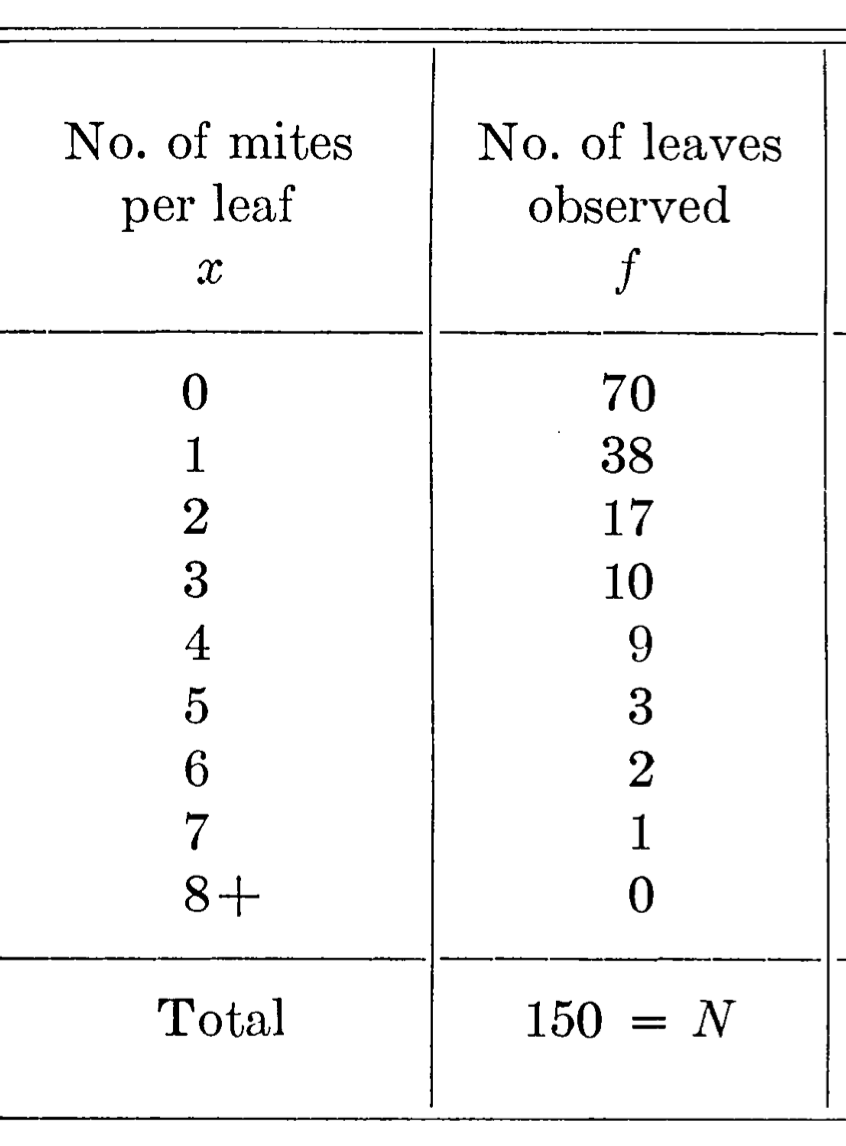

Let's load the data:

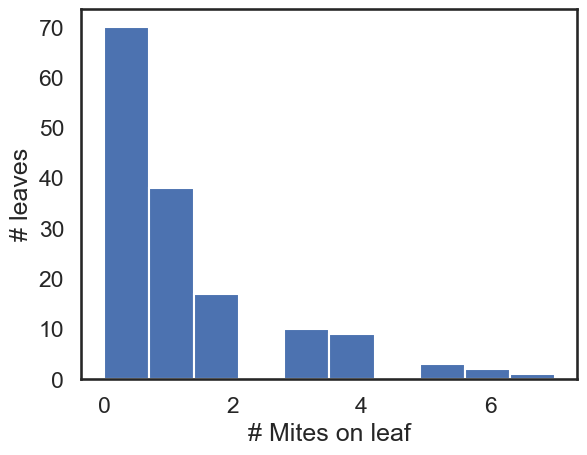

In [25]:
X = np.array(loadtxt('../data/mites.csv', delimiter=','))
plt.hist(X)
plt.xlabel('# Mites on leaf')
plt.ylabel('# leaves');

Now infer with the Poisson model:

In [26]:
μ_hat = X.mean()
Xs = random.choice(subkey, X, shape=(N,n), replace=True)
μ_hats = Xs.mean(axis=1)
ci_low = np.quantile(μ_hats, α/2)
ci_high = np.quantile(μ_hats, 1-α/2)

print("μ_hat = {:.4f} [95% CI, {:.4f}-{:.4f}]".format(μ_hat, ci_low, ci_high))
print(r'Avg(X)'+'={:.4f}, Var(X)={:.4f}'.format(X.mean(), X.var(ddof=1)))

μ_hat = 1.1467 [95% CI, 0.9133-1.3867]
Avg(X)=1.1467, Var(X)=2.2736


We inferred ~1.15 mites per leaf, but the variance seems to be about double the average, which suggests the fit is poor. 

Let's check the model as we did above.

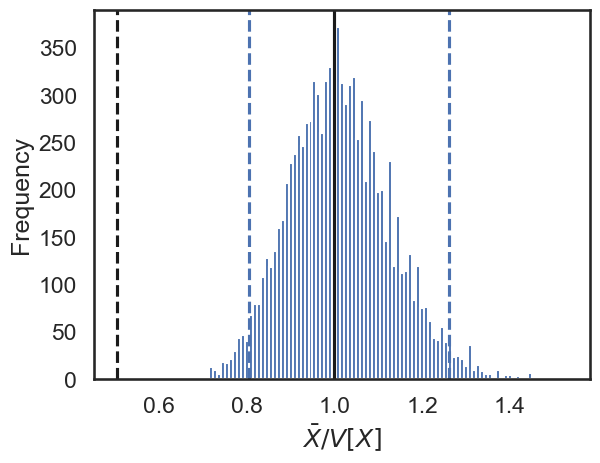

In [27]:
key,subkey = random.split(key)
Xs = random.poisson(subkey, μ_hat, shape=(N,n))
ratios = Xs.mean(axis=1)/Xs.var(ddof=1, axis=1)
plt.hist(ratios, 100)
plt.axvline(1, ls='-', color='k')
plt.axvline(X.mean()/ X.var(ddof=1), ls='--', color='k')
plt.axvline(np.quantile(ratios, 0.025), ls='--')
plt.axvline(np.quantile(ratios, 0.975), ls='--')
plt.xlabel(r'$\bar{X}/V[X]$')
plt.ylabel('Frequency');

The observed mean/variance ratio is much smaller than expected, and outside of the 95% CI - and even the 100% CI.

So we should reject the Poisson model. What now?

# Over-dispersed model for count data

A common distribution for modeling over-dispersed count data is the [Negative Binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution), such that
$$
x_i \sim NB(r, p)
$$
with $r$ and $p$ as the model parameters that define the expected value $r \frac{1-p}{p}$ and the variance $r \frac{1-p}{p^2}$, so that the variance scales with the expected value.

# Synthetic data
Let's simulate data according to this over-dispersed model. JAX does not implement drawing random numbers from this distribution, so we use NumPy.

In [28]:
import numpy as onp
# for reproducibility
onp.random.default_rng(3233)
n = 150
θ = (r, p) = 5.0, 0.5

X = onp.random.negative_binomial(r, p, size=n)
print(r'Avg(X)'+'={:.4f}, Var(X)={:.4f}'.format(X.mean(), X.var(ddof=1)))

Avg(X)=4.6000, Var(X)=10.6040


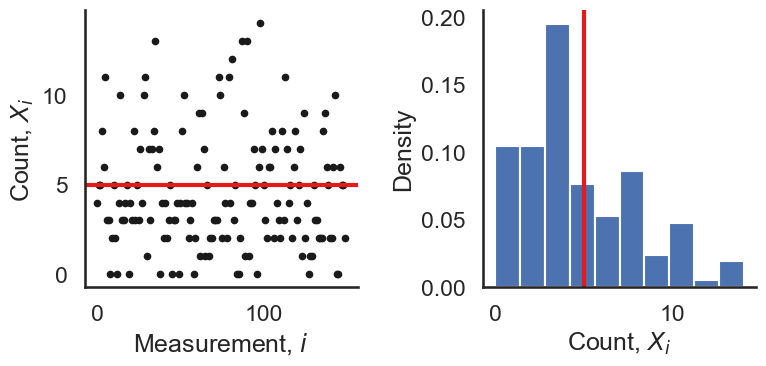

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(r*(1-p)/p, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Count, $X_i$")

ax = axes[1]
ax.hist(X, bins=10, density=True)
ax.axvline(r*(1-p)/p, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Density")
ax.set_xlabel("Count, $X_i$")

fig.tight_layout()
sns.despine()

# Inference with the Poisson model

Let's start by testing how this data fits the Poisson model.

μ_hat = 4.6000
Avg(X)=4.6000, Var(X)=10.6040


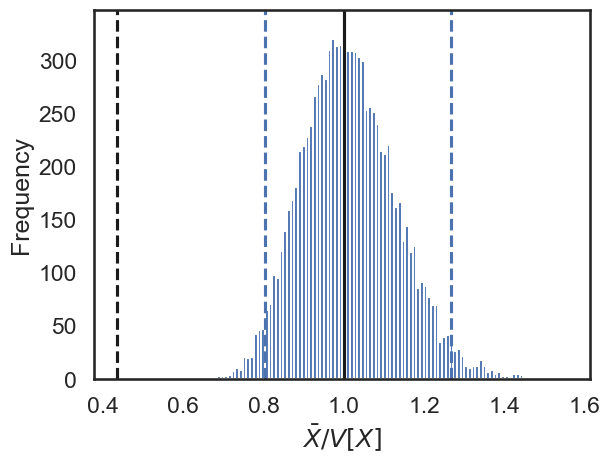

In [30]:
μ_hat = X.mean()
print("μ_hat = {:.4f}".format(μ_hat))
print(r'Avg(X)'+'={:.4f}, Var(X)={:.4f}'.format(X.mean(), X.var(ddof=1)))

key,subkey = random.split(key)
Xs = random.poisson(subkey, μ_hat, shape=(N, n))
ratios = Xs.mean(axis=1)/Xs.var(ddof=1, axis=1)
plt.hist(ratios, 100)
plt.axvline(1, ls='-', color='k')
plt.axvline(X.mean()/ X.var(ddof=1), ls='--', color='k')
plt.axvline(np.quantile(ratios, 0.025), ls='--')
plt.axvline(np.quantile(ratios, 0.975), ls='--')
plt.xlabel(r'$\bar{X}/V[X]$')
plt.ylabel('Frequency');

So the Poisson model is rejected.

# Maximum likelihood estimation with negative binomial distribution

The likelihood function is given by the negative binomial distribution,
$$
p(X \mid r, p) = 
\prod_{i=1}^{n}{\binom{x_i +r -1}{x_i} (1-p)^{x_i} p^r}
$$

We therefore implement the negative log likelihood function `NLL(θ, X)`, where $\theta = (r, \phi)$ , $p=\phi/(\phi+1)$, and `X` is the data.

In [31]:
def NLL(θ, X):
    r, p = θ
    return -stats.nbinom.logpmf(X, r, p).sum()

print(NLL(θ, X))

378.94772


Computing the log-likelihood for a grid of $r$ and $\phi$ values can take a couple of minutes.

In [32]:
r_range = np.linspace(0.5, 10, 100)
p_range = np.linspace(0.01, 0.99, 101)
θ_range = np.array(np.meshgrid(r_range, p_range, indexing='ij'))

In [34]:
vmap_NLL = jax.vmap( # vmap makes this much faster than nested for loops
    jax.vmap(NLL, in_axes=(1, None)), # vecotize over r only. do not vectorize over X.
    in_axes=(2, None) # vectorize over p only. do not vectorize over X.
)
nlls = vmap_NLL(θ_range, X)

In [33]:
θ_range.shape

(2, 100, 101)

In [35]:
nlls.shape

(101, 100)

In [36]:
θ_hat = θ_range[:, (nlls==nlls.min()).T].squeeze()
r_hat, p_hat = θ_hat
print("r = {} \tr_hat = {:.4f}\np = {}\t\tp_hat = {:.4f}".format(r, r_hat, p, p_hat))

r = 5.0 	r_hat = 3.0909
p = 0.5		p_hat = 0.4020


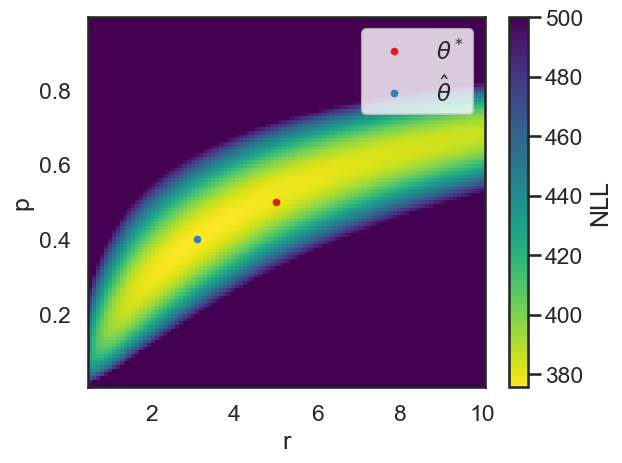

In [38]:
im = plt.pcolormesh(r_range, p_range, nlls, cmap='viridis_r', vmin=nlls.min(), vmax=500)
plt.colorbar(im, label='NLL')
plt.plot(r, p, '.', color=red, label=r'$θ^*$')
plt.plot(r_hat, p_hat, '.', color=blue, label=r'$\hat\theta$')
plt.legend()
plt.xlabel('r')
plt.ylabel('p');

Let's see if we got a good fit.

Avg(X)=4.6000, Var(X)=10.6040


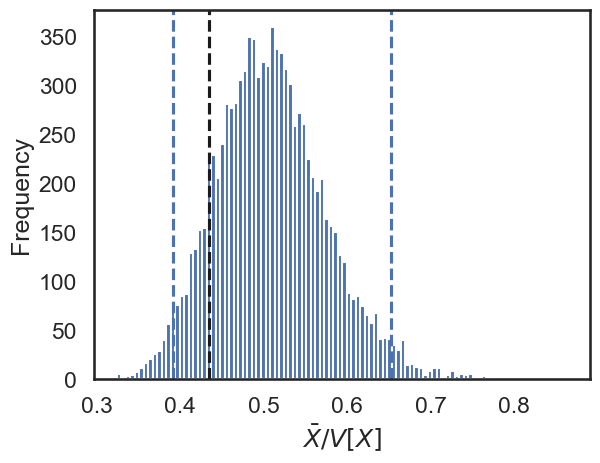

In [39]:
print(r'Avg(X)'+'={:.4f}, Var(X)={:.4f}'.format(X.mean(), X.var(ddof=1)))

key, subkey = random.split(key)
Xs = onp.random.negative_binomial(r, p, size=(N,n))
ratios = Xs.mean(axis=1) / Xs.var(ddof=1, axis=1)
plt.hist(ratios, 100)
plt.axvline(X.mean()/ X.var(ddof=1), ls='--', color='k')
plt.axvline(np.quantile(ratios, 0.025), ls='--')
plt.axvline(np.quantile(ratios, 0.975), ls='--')
plt.xlabel(r'$\bar{X}/V[X]$')
plt.ylabel('Frequency');

So the over-dispersed model check out (on data generated from the model!)

# Inference on real data with over-dispersed Poisson model 

Let's try out this over-dispersed Poisson model on our real "mites on leaves" data.

We reload our data and proceed for the maximum likelihood estimation.

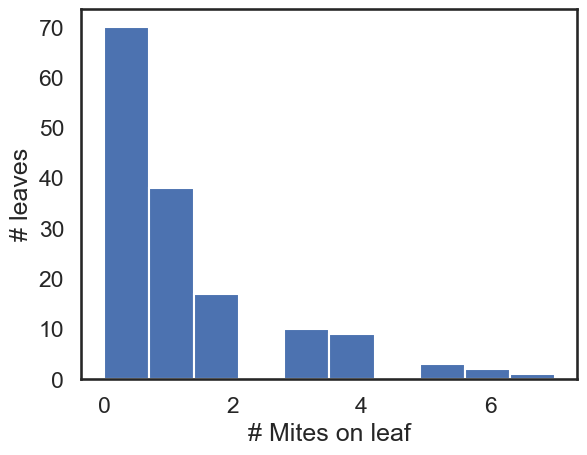

In [40]:
X = np.array(loadtxt('../data/mites.csv', delimiter=','))
plt.hist(X)
plt.xlabel('# Mites on leaf')
plt.ylabel('# leaves');

In [41]:
r_range = np.linspace(0.5, 10, 100)
p_range = np.linspace(0.01, 0.99, 101)
θ_range = np.array(np.meshgrid(r_range, p_range, indexing='ij'))

vmap_NLL = jax.vmap( # vmap makes this much faster than nested for loops
    jax.vmap(NLL, in_axes=(1, None)),
    in_axes=(2, None)
)
nlls = vmap_NLL(θ_range, X)
θ_hat = θ_range[:, (nlls==nlls.min()).T].squeeze()
r_hat, p_hat = θ_hat
print("r_hat = {:.4f}\np_hat = {:.4f}".format(r_hat, p_hat))

r_hat = 0.9798
p_hat = 0.4608


μ_hat = 4.6000
Avg(X)=1.1467, Var(X)=2.2736


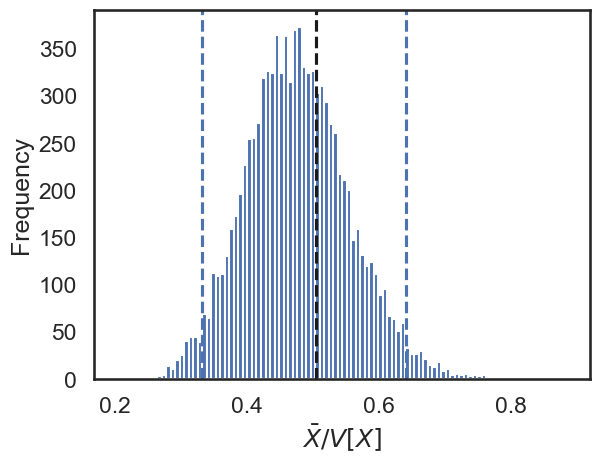

In [44]:
print("μ_hat = {:.4f}".format(μ_hat))
print(r'Avg(X)'+'={:.4f}, Var(X)={:.4f}'.format(X.mean(), X.var(ddof=1)))

def generate(r, p, shape):
    return onp.random.negative_binomial(r, p, size=shape)

key,subkey = random.split(key)
Xs = generate(r_hat, p_hat, shape=(N,n))
ratios = Xs.mean(axis=1) / Xs.var(ddof=1, axis=1)
plt.hist(ratios, 100)
plt.axvline(X.mean() / X.var(ddof=1), ls='--', color='k')
plt.axvline(np.quantile(ratios, 0.025), ls='--')
plt.axvline(np.quantile(ratios, 0.975), ls='--')
plt.xlabel(r'$\bar{X}/V[X]$')
plt.ylabel('Frequency');

So we have inferred the values and checked the model.

Let's use the bootstrap to estimate confidence interval, so that we have a measure of the uncertainty of our MLE.

In [45]:
N = 1000
key, subkey = random.split(key)
Xs = random.choice(subkey, X, shape=(N, n), replace=True).astype(X.dtype)

def mle(X):
    nlls = vmap_NLL(θ_range, X)
    θ_hat = θ_range[:, (nlls==nlls.min()).T].squeeze()
    return θ_hat

In [46]:
%%time
θ_bootstrap = np.array([mle(Xi) for Xi in Xs])
r_bootstrap, p_bootstrap = θ_bootstrap.T

CPU times: total: 12.4 s
Wall time: 20.9 s


We can visualize the approximated sampling distribution using a **corner plot** using the [corner](http://corner.readthedocs.io) package.

The diagonal plots show the histogram of the parameter estimates, and the joint plot (bottom left) shows a joint 2D histogram of the parameter estimates.
The contours on the joint plot shows standard deviations to demonstrate confidence regions (the 2D equivalent of confidence intervals).

In [47]:
from corner import corner
from numpy import asarray

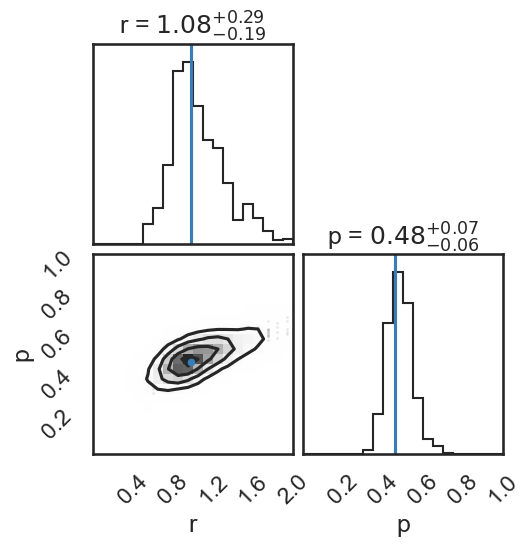

In [49]:
cor = corner(asarray(θ_bootstrap),
    smooth=True,
    labels=['r', 'p'],
    show_titles=True,
    range=[(0, 2), (0, 1)]
)
cor.axes[0].axvline(r_hat, color=blue)
cor.axes[3].axvline(p_hat, color=blue)
cor.axes[2].plot(r_hat, p_hat, '.', color=blue);

# References

- ProbML - [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html) by Kevin P. Murphy. Online version. June 26, 2024
- Jake VanDerPlas's series of [blog posts on Frequentists vs. Bayesian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
- In All Likelihood by Yudi Pawitan, ch. 4.5.
- Kass, Richard E. 2011. [Statistical inference: The big picture](http://www.stat.cmu.edu/~kass/papers/bigpic.pdf). Stat Sci. doi:10.1214/10-STS337
- Bliss, C. I., and R. A. Fisher. 1953. [Fitting the Negative Binomial Distribution to Biological Data](https://doi.org/10.2307/3001850). Biometrics. doi:10.2307/3001850
- The Poisson and other distributions are animated at [Seeing Theory](https://seeing-theory.brown.edu/probability-distributions/index.html#section2)
- The bootstrap is visualized at [Seeing Theory](https://seeing-theory.brown.edu/frequentist-inference/index.html#section3).

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.